# FCN

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchmetrics

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/Users/louis/anaconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## Dataset

In [3]:
data_dir = '../dataset/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
unlabel_dir = data_dir + 'unlabeled/'

In [4]:
class MaskDataset(Dataset):
    def __init__(self, root='../dataset/train/', transform=None):
        self.root = root
        self.transform = transform
        self.vid_list = sorted(os.listdir(root))
        self.img_list = ['image_' + str(i) + '.png' for i in range(22)]
    
    def __len__(self):
        return len(self.vid_list) * 22

    def __getitem__(self, idx):
        vid_idx = idx // 22
        img_idx = idx % 22
        # load image
        img_path = os.path.join(self.root, self.vid_list[vid_idx], self.img_list[img_idx])
        img = Image.open(img_path).convert("RGB")
        # load mask
        mask_path = os.path.join(self.root, self.vid_list[vid_idx], 'mask.npy')
        target = np.load(mask_path)[img_idx]
        # transforms
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset_train = MaskDataset(transform=transform)

In [6]:
dataloader = DataLoader(
    dataset_train,
    batch_size=8,
    shuffle=True,
)

img, target = next(iter(dataloader))
print(img.shape, target.shape)

torch.Size([8, 3, 160, 240]) torch.Size([8, 160, 240])


## Data Augmentation

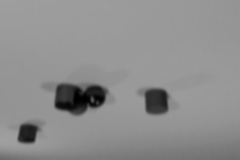

In [7]:
import torchvision.transforms as T

brightness = 0.4
contrast = 0.4
saturation = 0.4

transform = T.Compose([
    T.RandomResizedCrop(size=(160, 240), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(
        brightness=0.8,
        contrast=0.8,
        saturation=0.8,
    ),
    T.GaussianBlur(kernel_size=(3, 11), sigma=(0.3, 2.5)),
    T.RandomGrayscale(p=0.2),
    # T.PILToTensor(),
    # T.ConvertImageDtype(torch.float),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset_train = MaskDataset(transform=transform)
dataset_train[-1][0]

In [8]:
dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)
img, target = next(iter(dataloader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

## Train

In [ ]:
lr = 1e-2
batch_size = 8

In [ ]:
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [ ]:
model = models.segmentation.fcn_resnet50(
    weights=None,
    weights_backbone=models.ResNet50_Weights.IMAGENET1K_V2, 
    num_classes=49,
    aux_loss=True
).to(device)
model

In [ ]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

In [ ]:
params_to_optimize = [
    {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
    {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
]

params = [p for p in model.aux_classifier.parameters() if p.requires_grad]
params_to_optimize.append({"params": params, "lr": lr * 10})

optimizer = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

In [ ]:
for epoch in range(1):
    print(epoch)
    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)
        
        output = model(imgs)
        loss = criterion(output, targets.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(loss.item())


## Evaluation

In [ ]:
imgs, targets = next(iter(dataloader))
# imgs, targets = img.to(device), targets.to(device)

outputs = model(imgs.to(device))

In [ ]:
imgs.size(0)

In [ ]:
output = outputs['out']
output.shape

In [ ]:
output = output.cpu().detach().numpy()
output_predictions = output.argmax(1)
output_predictions.shape
bg = torch.zeros_like(targets)

In [ ]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49
                                    , average='micro'
                                    )

output_predictions = bg
print(jaccard(torch.Tensor(output_predictions), targets).item())

s = 0.0
for i in range(8):
    j = jaccard(torch.Tensor(output_predictions[i]), targets[i]).item()
    s += j

s / 8

In [ ]:
plt.imshow(imgs[0].permute(1,2,0))

In [ ]:
plt.imshow(output_predictions[0])
output_predictions[0]

In [ ]:
plt.imshow(targets[0])

## Inference

In [9]:
model_path = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/segmentation/output/fcn_resnet50_jaccard_0.1826/fcn_resnet50_best.pth'

model = models.segmentation.fcn_resnet50(num_classes=49, aux_loss=True)

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model = model.to(device)

In [372]:
imgs, targets = next(iter(dataloader))
imgs = imgs.to(device)

outputs = model(imgs)
outs = outputs['out'].cpu().detach().numpy()
out_pred = outs.argmax(1)
out_pred.shape

(8, 160, 240)

array([ 0,  8, 23, 27, 29, 30, 39, 40])

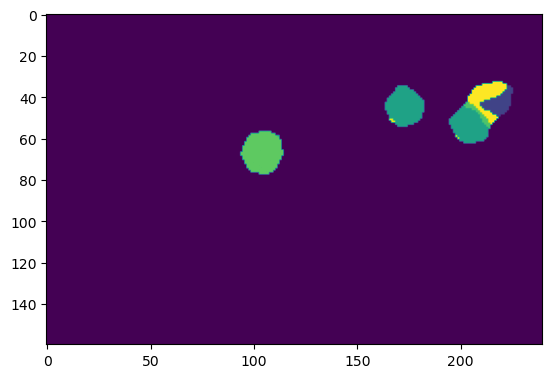

In [373]:
plt.imshow(out_pred[0])
out_pred.max()
np.unique(out_pred[0])

array([ 0, 16, 26, 27, 30], dtype=uint8)

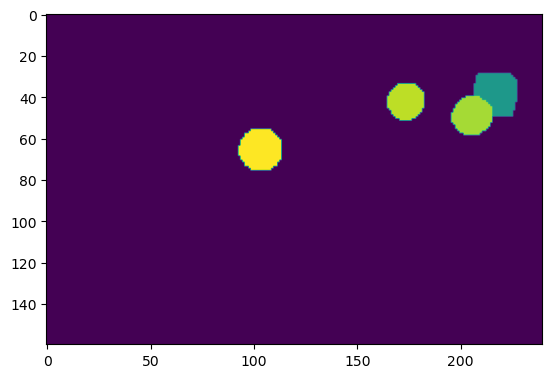

In [374]:
plt.imshow(targets[0].cpu())
np.unique(targets[0])

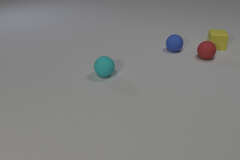

In [375]:
transformtoPIL = transforms.ToPILImage()
def unnormalize(img):
    #unnormalize the image
    for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    img = transformtoPIL(img)
    return img

unnormalize(imgs[0])

In [ ]:
shapes = ["cube", "sphere", "cylinder"]
materials = ["metal", "rubber"]
colors = ["gray", "red", "blue", "green", "brown", "cyan", "purple", "yellow"]

def get_id(the_object):
    color = the_object['color']
    material = the_object['material']
    shape = the_object['shape']
    
    c_id = colors.index(color)
    m_id = materials.index(material)
    s_id = shapes.index(shape)
    
    obj_id = s_id * 16 + m_id * 8 + c_id + 1
    
    return obj_id

In [47]:
for i in [0, 4]:
    torch.nn.init.xavier_uniform_(model.classifier[i].weight)
    # torch.nn.init.xavier_uniform_(model.aux_classifier[i].weight)

In [46]:
i = 4
torch.nn.init.xavier_uniform_(model.classifier[i].weight)

Parameter containing:
tensor([[[[-0.0970]],

         [[-0.0369]],

         [[ 0.0568]],

         ...,

         [[-0.0243]],

         [[-0.0622]],

         [[-0.0064]]],


        [[[ 0.0041]],

         [[ 0.0795]],

         [[-0.0491]],

         ...,

         [[-0.0637]],

         [[-0.0206]],

         [[-0.0537]]],


        [[[-0.0891]],

         [[-0.0096]],

         [[-0.0682]],

         ...,

         [[ 0.0435]],

         [[-0.0156]],

         [[ 0.0713]]],


        ...,


        [[[-0.0738]],

         [[ 0.0702]],

         [[ 0.0253]],

         ...,

         [[-0.0341]],

         [[ 0.0680]],

         [[-0.0582]]],


        [[[-0.0129]],

         [[-0.0508]],

         [[ 0.0043]],

         ...,

         [[ 0.0157]],

         [[-0.0282]],

         [[ 0.0278]]],


        [[[ 0.0575]],

         [[ 0.0887]],

         [[-0.0316]],

         ...,

         [[-0.0938]],

         [[-0.0451]],

         [[-0.0067]]]], device='mps:0', requires_grad=True